# Churn-Analyse und Prävention für E-Commerce-Kunden

## Einleitung

In diesem Projekt analysieren wir die Kundenabwanderung (Churn) eines E-Commerce-Unternehmens. Ziel ist es, ein prädiktives Modell zu entwickeln, das gefährdete Kunden identifiziert, um gezielte Maßnahmen zur Kundenbindung ergreifen zu können. Wir verwenden einen Logistic Regression Klassifikator mit Bagging, um die Vorhersagegenauigkeit zu verbessern.


## Datenvorbereitung

Zuerst laden wir den Datensatz, bereinigen die Daten und führen notwendige Transformationen durch.


In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [48]:
p1 = pd.read_csv('online_retail_customer_churn.csv', encoding='ISO-8859-1')

p1.head()

,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


In [49]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 1000 non-null   int64  
 1   Age                         1000 non-null   int64  
 2   Gender                      1000 non-null   object 
 3   Annual_Income               1000 non-null   float64
 4   Total_Spend                 1000 non-null   float64
 5   Years_as_Customer           1000 non-null   int64  
 6   Num_of_Purchases            1000 non-null   int64  
 7   Average_Transaction_Amount  1000 non-null   float64
 8   Num_of_Returns              1000 non-null   int64  
 9   Num_of_Support_Contacts     1000 non-null   int64  
 10  Satisfaction_Score          1000 non-null   int64  
 11  Last_Purchase_Days_Ago      1000 non-null   int64  
 12  Email_Opt_In                1000 non-null   bool   
 13  Promotion_Response          1000 n

In [50]:
p1 = p1.drop('Customer_ID', axis=1) 
p1.describe()

,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,43.27,111.96,5080.79,9.73,49.46,266.88,4.61,1.93,2.97,182.89
std,15.24,52.84,2862.12,5.54,28.54,145.87,2.90,1.40,1.39,104.39
min,18.00,20.01,108.94,1.00,1.00,10.46,0.00,0.00,1.00,1.00
25%,30.00,67.80,2678.68,5.00,25.00,139.68,2.00,1.00,2.00,93.00
50%,43.00,114.14,4986.19,9.00,49.00,270.10,5.00,2.00,3.00,180.50
75%,56.00,158.45,7606.47,14.00,74.00,401.60,7.00,3.00,4.00,274.00
max,69.00,199.73,9999.64,19.00,99.00,499.57,9.00,4.00,5.00,364.00


In [51]:
p1.isnull().values.any()

False

### Verteilung der Antworten auf Promotionen

Zunächst wird die Häufigkeitsverteilung der Variable `Promotion_Response` berechnet und ausgegeben:


Promotion_Response
Unsubscribed    361
Responded       338
Ignored         301
Name: count, dtype: int64


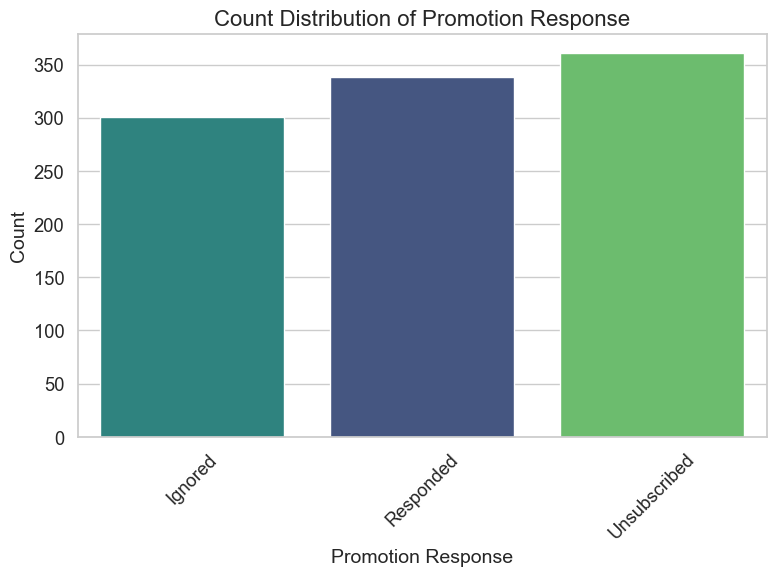

In [52]:
promo = p1['Promotion_Response'].value_counts()
print(promo)

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8,6))

promo_plot = sns.countplot(
    data=p1, 
    x='Promotion_Response', 
    hue='Promotion_Response', 
    order=p1['Promotion_Response'].value_counts(ascending=True).index, 
    palette='viridis', 
    dodge=False, 
    legend=False
)

plt.xlabel('Promotion Response', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count Distribution of Promotion Response', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In diesem Diagramm werden die Häufigkeiten der verschiedenen Antworten auf Promotionen auf der x-Achse dargestellt, sortiert nach aufsteigender Häufigkeit. Die y-Achse zeigt die Anzahl der Antworten.

### Überprüfung der Verteilung der E-Mail-Opt-Ins

In diesem Abschnitt analysieren wir die Verteilung der `Email_Opt_In`-Spalte, um zu verstehen, wie viele Kunden dem Erhalt von Werbe-E-Mails zugestimmt haben. Zunächst berechnen wir die Häufigkeitsverteilung und geben sie aus. Anschließend visualisieren wir diese Verteilung mit einem Kreisdiagramm.

Email_Opt_In
True     529
False    471
Name: count, dtype: int64


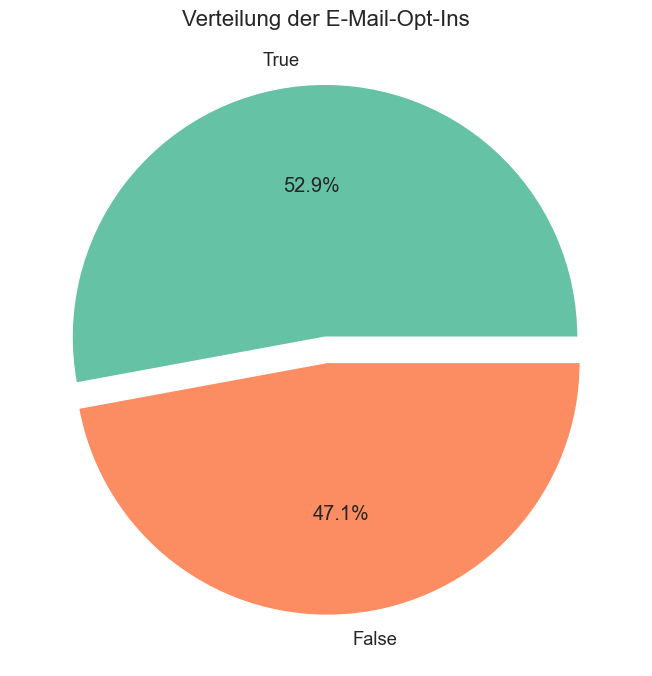

In [53]:
# Berechnung der Verteilung von Email_Opt_In
email = p1['Email_Opt_In'].value_counts()
print(email)

# Plot der Grafik
sns.set(font_scale=1.2)
plt.figure(figsize=(7,7))

email.plot(kind='pie', autopct='%0.1f%%', explode=[0.05, 0.05], colors=['#66c2a5', '#fc8d62'])
plt.ylabel('')
plt.title('Verteilung der E-Mail-Opt-Ins', fontsize=16)
plt.tight_layout()

# Anzeige der Grafik
plt.show()


In diesem Kreisdiagramm zeigt jeder Abschnitt den Anteil der Kunden, die sich für den Erhalt von Werbe-E-Mails entschieden haben, im Vergleich zu denen, die dies nicht getan haben.

### Überprüfung der Verteilung des Geschlechts

In diesem Abschnitt analysieren wir die Verteilung der `Gender`-Spalte, um zu verstehen, wie sich die Geschlechterverteilung unter den Kunden darstellt. Zunächst berechnen wir die Häufigkeitsverteilung und geben sie aus. Anschließend visualisieren wir diese Verteilung mit einem Kreisdiagramm.

Gender
Female    342
Male      334
Other     324
Name: count, dtype: int64


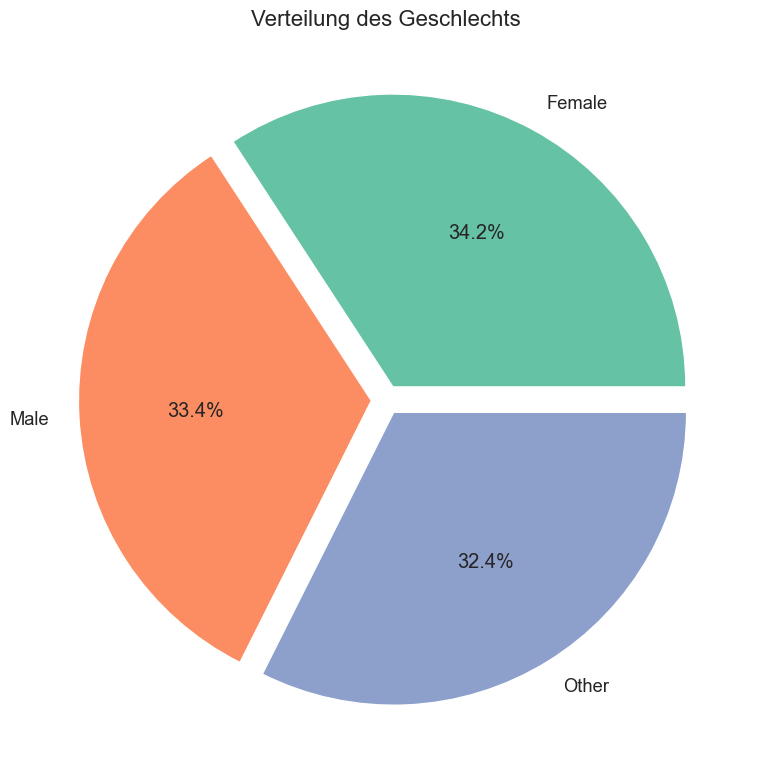

In [54]:
# Berechnung der Verteilung von Gender
gen = p1['Gender'].value_counts()
print(gen)

# Plot der Grafik
sns.set(font_scale=1.2)
plt.figure(figsize=(8,8))

v1 = p1['Gender'].value_counts()
v1.plot(kind='pie', autopct='%0.1f%%', explode=[0.05, 0.05, 0.05], colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.ylabel('')
plt.title('Verteilung des Geschlechts', fontsize=16)
plt.tight_layout()

# Anzeige der Grafik
plt.show()

In diesem Kreisdiagramm zeigt jeder Abschnitt den Anteil der verschiedenen Geschlechter unter den Kunden.

### Überprüfung auf Ausreißer für Alter, Jahreseinkommen, Gesamtausgaben und Kundenjahre

In diesem Abschnitt analysieren wir die Verteilung und mögliche Ausreißer in den Variablen `Age`, `Annual_Income`, `Total_Spend` und `Years_as_Customer`. Dazu verwenden wir Boxplots, die eine effiziente Methode zur Identifizierung von Ausreißern bieten. Jede der vier Variablen wird in einem separaten Subplot dargestellt.

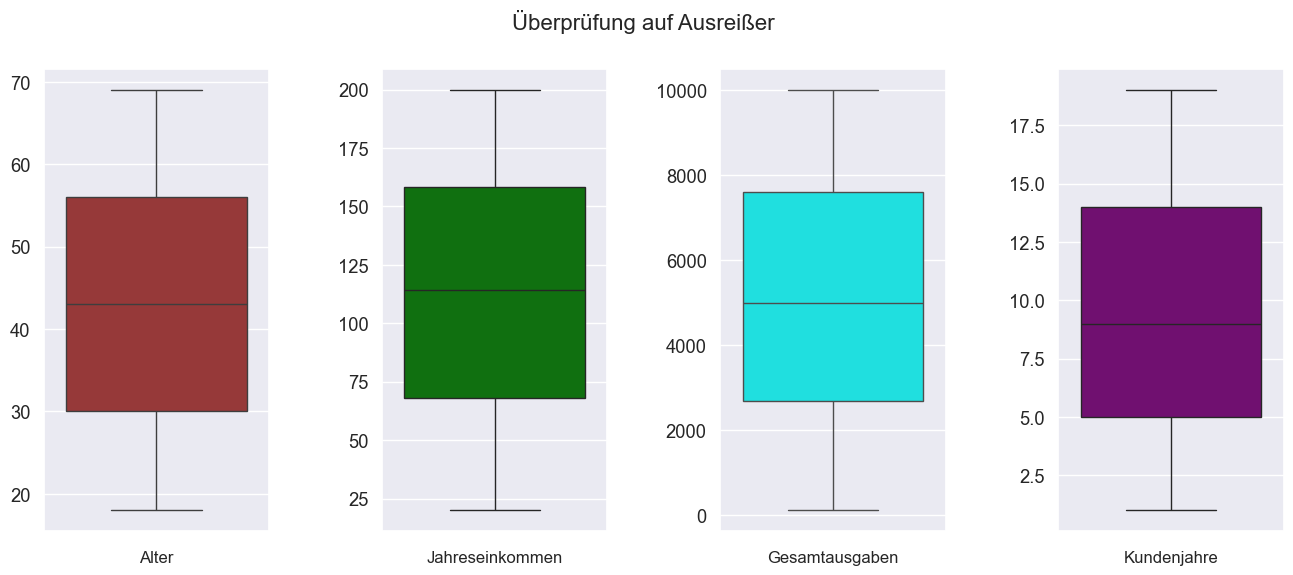

In [55]:
# Erstellung von 4 Boxplots
fig, ax = plt.subplots(1, 4, figsize=(16, 6))

# Abstand zwischen den Plots schaffen
plt.subplots_adjust(wspace=0.5) 

# Boxplot für Age im ersten Subplot
sns.boxplot(data=p1, y='Age', ax=ax[0], color='brown')
ax[0].set_xlabel('Alter', fontsize=12)
ax[0].set_ylabel('')

# Boxplot für Annual_Income im zweiten Subplot
sns.boxplot(data=p1, y='Annual_Income', ax=ax[1], color='green')
ax[1].set_xlabel('Jahreseinkommen', fontsize=12)
ax[1].set_ylabel('')

# Boxplot für Total_Spend im dritten Subplot
sns.boxplot(data=p1, y='Total_Spend', ax=ax[2], color='cyan')
ax[2].set_xlabel('Gesamtausgaben', fontsize=12)
ax[2].set_ylabel('')

# Boxplot für Years_as_Customer im vierten Subplot
sns.boxplot(data=p1, y='Years_as_Customer', ax=ax[3], color='purple')
ax[3].set_xlabel('Kundenjahre', fontsize=12)
ax[3].set_ylabel('')

# Entfernung der x-Achsenbeschriftungen
for subplot in ax:
    subplot.set_xticklabels([])

# Anzeige der Plots
plt.suptitle('Überprüfung auf Ausreißer', fontsize=16)
plt.show()

In den Boxplots sehen wir, wie die Werte der einzelnen Variablen verteilt sind und ob es potenzielle Ausreißer gibt, die möglicherweise weitere Untersuchungen erfordern.

### Überprüfung auf Ausreißer für Zufriedenheitsbewertung, Letzter Einkauf (Tage) und Anzahl der Rücksendungen

In diesem Abschnitt analysieren wir die Verteilung und mögliche Ausreißer in den Variablen `Satisfaction_Score`, `Last_Purchase_Days_Ago` und `Num_of_Returns`. Dazu verwenden wir Boxplots, die eine effiziente Methode zur Identifizierung von Ausreißern bieten. Jede der drei Variablen wird in einem separaten Subplot dargestellt.



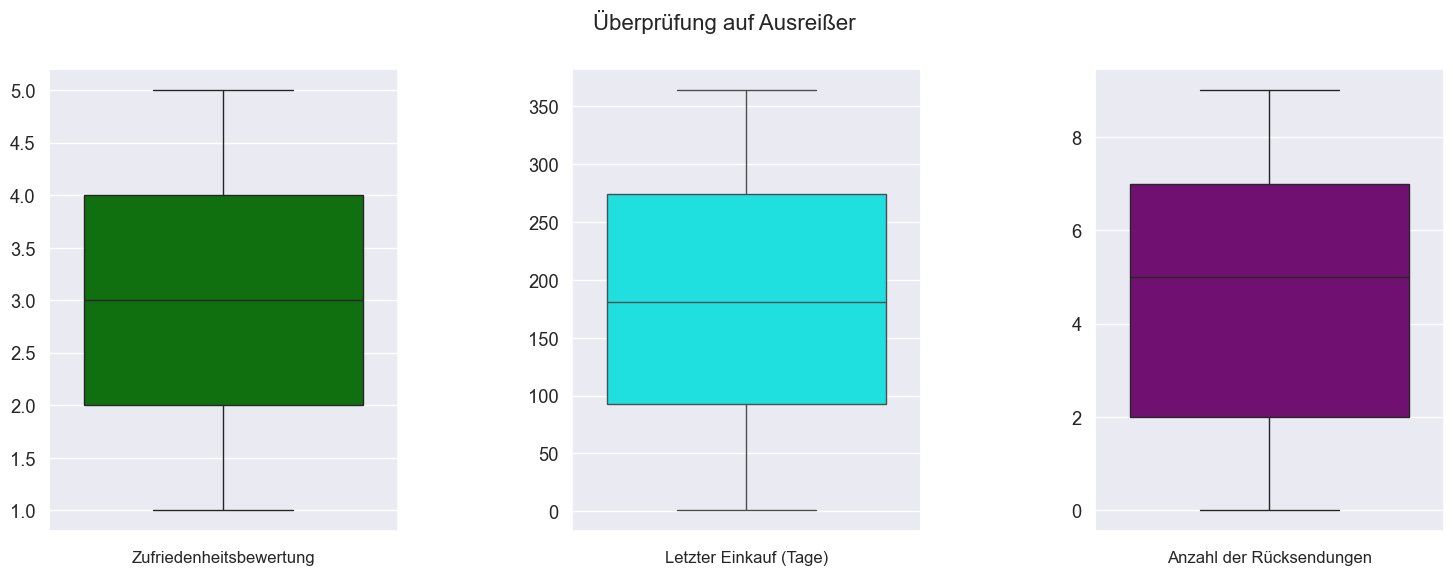

In [56]:
# Erstellung von 3 Boxplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Abstand zwischen den Plots schaffen
plt.subplots_adjust(wspace=0.5) 

# Boxplot für Satisfaction_Score im ersten Subplot
sns.boxplot(data=p1, y='Satisfaction_Score', ax=ax[0], color='green')
ax[0].set_xlabel('Zufriedenheitsbewertung', fontsize=12)
ax[0].set_ylabel('')

# Boxplot für Last_Purchase_Days_Ago im zweiten Subplot
sns.boxplot(data=p1, y='Last_Purchase_Days_Ago', ax=ax[1], color='cyan')
ax[1].set_xlabel('Letzter Einkauf (Tage)', fontsize=12)
ax[1].set_ylabel('')

# Boxplot für Num_of_Returns im dritten Subplot
sns.boxplot(data=p1, y='Num_of_Returns', ax=ax[2], color='purple')
ax[2].set_xlabel('Anzahl der Rücksendungen', fontsize=12)
ax[2].set_ylabel('')

# Entfernung der x-Achsenbeschriftungen
for subplot in ax:
    subplot.set_xticklabels([])

# Anzeige der Plots
plt.suptitle('Überprüfung auf Ausreißer', fontsize=16)
plt.show()


In den Boxplots sehen wir, wie die Werte der einzelnen Variablen verteilt sind und ob es potenzielle Ausreißer gibt, die möglicherweise weitere Untersuchungen erfordern.

### Erstellung einer Korrelations-Heatmap

In diesem Abschnitt erstellen wir eine Heatmap, um die Korrelationen zwischen den numerischen Variablen in unserem Datensatz zu visualisieren. Durch das Entfernen der kategorialen Variablen und der Zielvariable können wir uns auf die Beziehungen zwischen den numerischen Variablen konzentrieren.

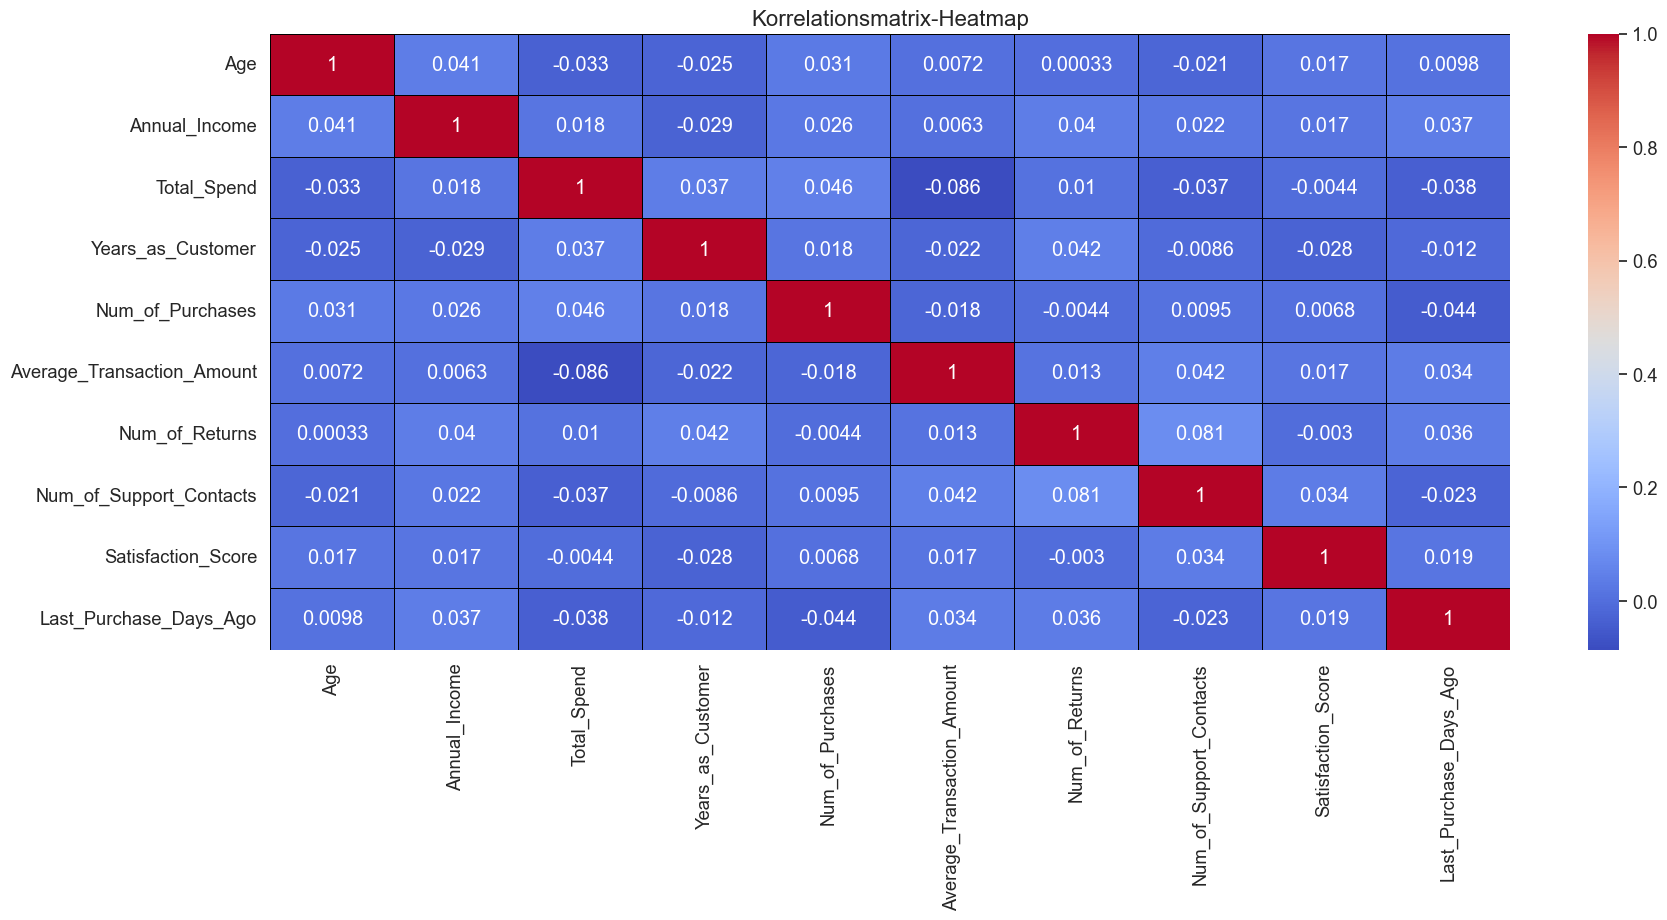

In [57]:
# Entfernen der kategorialen Variablen und der Zielvariable
p2 = p1.drop(['Gender', 'Promotion_Response', 'Email_Opt_In', 'Target_Churn'], axis=1)

# Erstellung der Korrelationsmatrix
corr_matrix = p2.corr()

# Plot der Heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')

# Anzeige der Grafik
plt.title('Korrelationsmatrix-Heatmap', fontsize=16)
plt.show()

### Überprüfung der Verteilung des Churn-Status

In diesem Abschnitt analysieren wir die Verteilung des `Target_Churn`-Status, um festzustellen, ob die Klassen ausgeglichen sind. Ein unausgeglichener Datensatz kann die Leistung von Vorhersagemodellen beeinflussen, daher ist es wichtig, dies zu überprüfen.

Target_Churn
True     526
False    474
Name: count, dtype: int64


C:\Users\julie\AppData\Local\Temp\ipykernel_27032\1420157017.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  res = sns.countplot(data=p1, x='Target_Churn', saturation=1, palette='viridis')


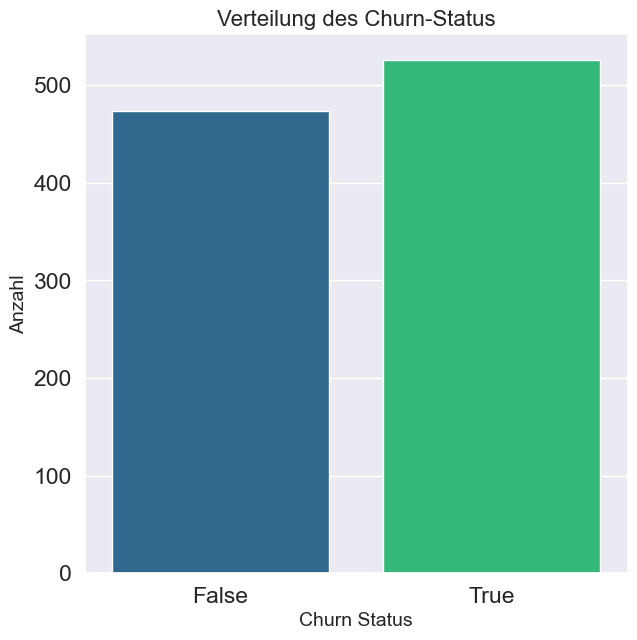

In [58]:
# Berechnung der Verteilung von Target_Churn
churn_counts = p1['Target_Churn'].value_counts(dropna=False)
print(churn_counts)

# Plot der Verteilung
sns.set(font_scale=1.5)
plt.figure(figsize=(7,7))

res = sns.countplot(data=p1, x='Target_Churn', saturation=1, palette='viridis')
plt.xlabel('Churn Status', fontsize=14)
plt.title('Verteilung des Churn-Status', fontsize=16)
plt.ylabel('Anzahl', fontsize=14)
plt.show()

### Umwandlung der Zielvariablen `Target_Churn` in eine binäre Variable

Um die Zielvariable `Target_Churn` für maschinelles Lernen nutzbar zu machen, wandeln wir sie in eine binäre Variable um. In diesem Fall wird `True` in `1` und `False` in `0` umgewandelt. Diese Umwandlung ermöglicht es, die Variable direkt in Modellen zu verwenden, die binäre Klassifikation unterstützen.

In [59]:
# Umwandlung der Zielvariablen `Target_Churn` in eine binäre Variable
p1['Target_Churn'] = p1['Target_Churn'].map({True: 1, False: 0})

# Überprüfung der Umwandlung
p1.head()

,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,1
1,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,0
2,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,1
3,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,1
4,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,0


### Kodierung kategorialer Variablen

Um kategoriale Variablen für maschinelles Lernen nutzbar zu machen, kodieren wir sie in numerische Werte. Dies geschieht durch die Verwendung der `pd.get_dummies`-Funktion, die jede kategoriale Variable in mehrere binäre (0 oder 1) Variablen umwandelt. Diese Methode wird One-Hot-Encoding genannt.

In [60]:
# Kodierung der kategorialen Variablen
p2 = pd.get_dummies(p1, columns=['Gender', 'Email_Opt_In', 'Promotion_Response'], dtype=int)

# Überprüfung der Umwandlung
p2.head()

,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Target_Churn,Gender_Female,Gender_Male,Gender_Other,Email_Opt_In_False,Email_Opt_In_True,Promotion_Response_Ignored,Promotion_Response_Responded,Promotion_Response_Unsubscribed
0,62,45.15,5892.58,5,22,453.80,2,0,3,129,1,0,0,1,0,1,0,1,0
1,65,79.51,9025.47,13,77,22.90,2,2,3,227,0,0,1,0,1,0,0,1,0
2,18,29.19,618.83,13,71,50.53,5,2,2,283,1,0,1,0,1,0,0,1,0
3,21,79.63,9110.30,3,33,411.83,5,3,5,226,1,0,0,1,0,1,1,0,0
4,21,77.66,5390.88,15,43,101.19,3,0,5,242,0,0,0,1,1,0,0,0,1


### Trennung der Ziel- und Prädiktorvariablen und Aufteilung der Daten in Trainings- und Testdatensätze

In diesem Abschnitt trennen wir die Zielvariable `Target_Churn` von den Prädiktorvariablen. Anschließend teilen wir die Daten in Trainings- und Testdatensätze auf, wobei wir ein Verhältnis von 80:20 verwenden. Dies ermöglicht es uns, ein Modell zu trainieren und seine Leistung auf einem separaten Testdatensatz zu validieren.

In [68]:
# Y (Target_Churn) ist die unabhängige Variable
Y = p2['Target_Churn']

# X sind die abhängigen Variablen
X = p2.drop('Target_Churn', axis=1)

# Aufteilen der Daten in Trainings- und Testdatensätze im Verhältnis 80:20
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [66]:
# Überprüfung der Aufteilung
train_X.head()

,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Gender_Female,Gender_Male,Gender_Other,Email_Opt_In_False,Email_Opt_In_True,Promotion_Response_Ignored,Promotion_Response_Responded,Promotion_Response_Unsubscribed
29,69,146.10,2533.91,7,10,114.05,6,4,1,31,1,0,0,1,0,0,0,1
535,26,81.31,5023.89,10,13,428.96,2,4,5,106,0,0,1,0,1,1,0,0
695,43,149.79,346.96,2,57,146.05,7,1,1,171,1,0,0,1,0,0,0,1
557,55,56.35,8478.68,5,7,243.91,1,3,2,27,0,0,1,1,0,0,0,1
836,18,25.27,706.88,18,46,252.05,2,1,1,346,1,0,0,1,0,0,0,1


In [67]:
train_Y.head()

29     0
535    0
695    0
557    1
836    1
Name: Target_Churn, dtype: int64

In [69]:
test_X.head()

,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Gender_Female,Gender_Male,Gender_Other,Email_Opt_In_False,Email_Opt_In_True,Promotion_Response_Ignored,Promotion_Response_Responded,Promotion_Response_Unsubscribed
521,52,25.11,9641.11,11,99,98.47,0,1,1,221,0,0,1,0,1,0,0,1
737,51,123.95,6377.72,8,31,45.34,5,4,1,230,0,0,1,0,1,1,0,0
740,32,68.24,1565.24,17,29,310.36,5,0,4,201,0,1,0,1,0,1,0,0
660,19,21.12,3527.02,10,22,282.69,7,0,2,161,1,0,0,1,0,1,0,0
411,61,121.85,6130.72,9,59,246.33,5,2,2,49,0,1,0,0,1,0,0,1


In [70]:
test_Y.head()

521    1
737    1
740    1
660    1
411    0
Name: Target_Churn, dtype: int64

### Implementierung des ersten Modells: Logistische Regression

In diesem Abschnitt implementieren wir ein logistische Regressionsmodell. Zunächst skalieren wir die Merkmale, um sie für das Modell zu standardisieren. Dies verbessert die Modellleistung, insbesondere bei Algorithmen, die von der Skala der Eingabedaten beeinflusst werden, wie die logistische Regression.


In [71]:
# Merkmals-Skalierung für das Modell
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# Implementierung des logistischen Regressionsmodells
lr = LogisticRegression()
lr.fit(train_X, train_Y)

# Überprüfung des Trainings
print("Logistische Regression wurde trainiert.")

Logistische Regression wurde trainiert.


In [72]:
# Vorhersage mit dem Modell
fcast_Y = lr.predict(test_X)
fcast_Y = pd.DataFrame(fcast_Y, columns=['Predicted Values'])

# Bewertung des Modells: Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(test_Y, fcast_Y)
accuracy = accuracy_score(test_Y, fcast_Y)
cr = classification_report(test_Y, fcast_Y)

print('Confusion Matrix :\n', cm)
print('Accuracy :', accuracy)
print('Classification Report :\n', cr)

Confusion Matrix :
 [[23 71]
 [36 70]]
Accuracy : 0.465
Classification Report :
               precision    recall  f1-score   support

           0       0.39      0.24      0.30        94
           1       0.50      0.66      0.57       106

    accuracy                           0.47       200
   macro avg       0.44      0.45      0.43       200
weighted avg       0.45      0.47      0.44       200



### Implementierung der logistischen Regression mit Hyperparameter-Optimierung

In diesem Abschnitt implementieren wir ein logistisches Regressionsmodell mit Hyperparameter-Optimierung. Durch die Verwendung von `GridSearchCV` suchen wir nach den besten Hyperparametern, um die Leistung des Modells zu maximieren. Anschließend bewerten wir das Modell anhand von Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht.


In [75]:
# Definition des Hyperparameter-Rasters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Implementierung von GridSearchCV zur Hyperparameter-Optimierung
gs = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs.fit(train_X, train_Y)

# Bestes Modell
best = gs.best_estimator_

# Vorhersage mit dem besten Modell
fcast_Y = best.predict(test_X)
fcast_Y = pd.DataFrame(fcast_Y, columns=['Predicted Values'])

# Bewertung des Modells: Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht
cm = confusion_matrix(test_Y, fcast_Y)
accuracy = accuracy_score(test_Y, fcast_Y)
cr = classification_report(test_Y, fcast_Y)

print('Confusion Matrix :\n', cm)
print('Accuracy :', accuracy)
print('Classification Report :\n', cr)

Confusion Matrix :
 [[17 77]
 [30 76]]
Accuracy : 0.465
Classification Report :
               precision    recall  f1-score   support

           0       0.36      0.18      0.24        94
           1       0.50      0.72      0.59       106

    accuracy                           0.47       200
   macro avg       0.43      0.45      0.41       200
weighted avg       0.43      0.47      0.42       200



### Implementierung der logistischen Regression mit Bagging

In diesem Abschnitt implementieren wir ein logistische Regressionsmodell mit Bagging. Bagging (Bootstrap Aggregating) ist eine Technik, bei der mehrere Modelle trainiert werden, um die Vorhersagegenauigkeit zu verbessern und die Varianz zu reduzieren. Anschließend bewerten wir das Modell anhand von Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht.

In [77]:
# Implementierung des Bagging-Klassifikators mit logistischem Regressionsmodell
bag = BaggingClassifier(estimator=LogisticRegression(), n_estimators=10, random_state=42)
bag.fit(train_X, train_Y)

# Vorhersage mit dem Bagging-Modell
fcast_Y = bag.predict(test_X)
fcast_Y = pd.DataFrame(fcast_Y, columns=['Predicted Values'])

# Bewertung des Modells: Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht
cm = confusion_matrix(test_Y, fcast_Y)
accuracy = accuracy_score(test_Y, fcast_Y)
cr = classification_report(test_Y, fcast_Y)

print('Confusion Matrix :\n', cm)
print('Accuracy :', accuracy)
print('Classification Report :\n', cr)

Confusion Matrix :
 [[28 66]
 [38 68]]
Accuracy : 0.48
Classification Report :
               precision    recall  f1-score   support

           0       0.42      0.30      0.35        94
           1       0.51      0.64      0.57       106

    accuracy                           0.48       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.47      0.48      0.46       200



### Implementierung des zweiten Modells: Decision Tree-Modell

In diesem Abschnitt implementieren wir ein Entscheidungsbaum-Modell. Entscheidungsbäume sind eine beliebte Methode für Klassifikationsaufgaben, da sie leicht zu interpretieren und zu visualisieren sind. Anschließend bewerten wir das Modell anhand von Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht.

In [79]:
# Implementierung des Entscheidungsbaum-Klassifikators
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_X, train_Y)

# Vorhersage mit dem Entscheidungsbaum-Modell
fcast_Y = dt.predict(test_X)
fcast_Y = pd.DataFrame(fcast_Y, columns=['Predicted Values'])

# Bewertung des Modells: Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht
cm = confusion_matrix(test_Y, fcast_Y)
accuracy = accuracy_score(test_Y, fcast_Y)
cr = classification_report(test_Y, fcast_Y)

print('Confusion Matrix :\n', cm)
print('Accuracy :', accuracy)
print('Classification Report :\n', cr)

Confusion Matrix :
 [[52 42]
 [46 60]]
Accuracy : 0.56
Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.55      0.54        94
           1       0.59      0.57      0.58       106

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



### Implementierung des dritten Modells: Random Forest-Modell

In diesem Abschnitt implementieren wir ein Random Forest-Modell. Random Forests sind ein Ensemble-Lernverfahren, das aus mehreren Entscheidungsbäumen besteht und deren Vorhersagen kombiniert, um die Genauigkeit zu verbessern und Überanpassungen zu reduzieren. Anschließend bewerten wir das Modell anhand von Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht.

In [81]:
# Implementierung des Random Forest-Klassifikators
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_X, train_Y)

# Vorhersage mit dem Random Forest-Modell
fcast_Y = rf.predict(test_X)
fcast_Y = pd.DataFrame(fcast_Y, columns=['Predicted Values'])

# Bewertung des Modells: Genauigkeit, Verwirrungsmatrix und Klassifikationsbericht
cm = confusion_matrix(test_Y, fcast_Y)
accuracy = accuracy_score(test_Y, fcast_Y)
cr = classification_report(test_Y, fcast_Y)

print('Confusion Matrix :\n', cm)
print('Accuracy :', accuracy)
print('Classification Report :\n', cr)

Confusion Matrix :
 [[36 58]
 [33 73]]
Accuracy : 0.545
Classification Report :
               precision    recall  f1-score   support

           0       0.52      0.38      0.44        94
           1       0.56      0.69      0.62       106

    accuracy                           0.55       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.55      0.53       200



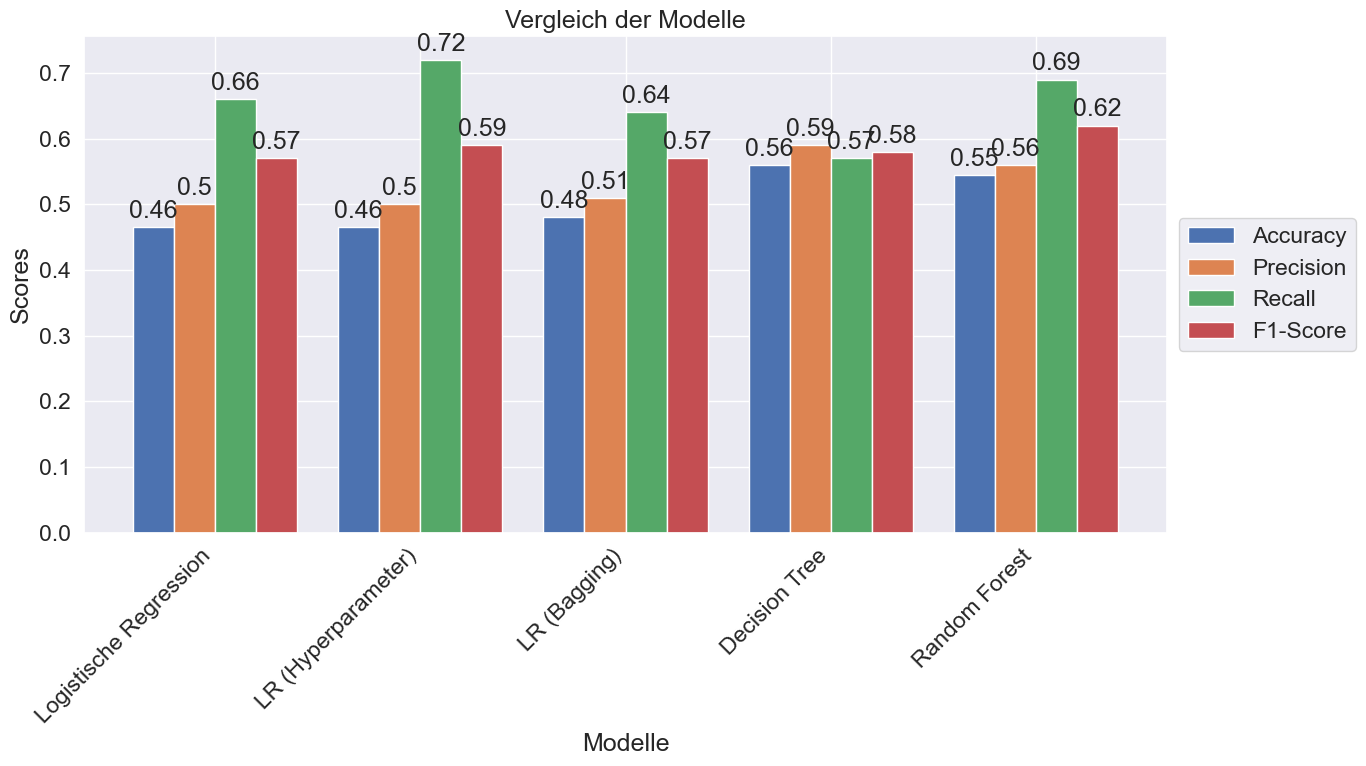

In [86]:
# Definieren der Modelle und ihrer Metriken
models = ['Logistische Regression', 'LR (Hyperparameter)', 'LR (Bagging)', 'Decision Tree', 'Random Forest']
accuracy = [0.465, 0.465, 0.48, 0.56, 0.545]
precision = [0.50, 0.50, 0.51, 0.59, 0.56]
recall = [0.66, 0.72, 0.64, 0.57, 0.69]
f1_score = [0.57, 0.59, 0.57, 0.58, 0.62]

# Erstellen des Diagramms
x = np.arange(len(models))  # die Label-Positionen
width = 0.2  # die Breite der Balken

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - 1.5 * width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5 * width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5 * width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5 * width, f1_score, width, label='F1-Score')

# Hinzufügen von Labels, Titel und Anpassen der Achsen
ax.set_xlabel('Modelle')
ax.set_ylabel('Scores')
ax.set_title('Vergleich der Modelle')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Hinzufügen der Werte über den Balken
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 Punkte vertikaler Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)
add_values(rects3)
add_values(rects4)

fig.tight_layout()
plt.show()


### Entscheidung:
**Genauigkeit (Accuracy):** Der Decision Tree hat die höchste Genauigkeit mit 0.56, gefolgt von Random Forest mit 0.545.

**Präzision (Precision) und Recall:** Beide Metriken sind bei Random Forest für die Klasse 1 besser als bei den anderen Modellen.

**F1-Score:** Der F1-Score ist bei Random Forest für die Klasse 1 mit 0.62 am höchsten, was bedeutet, dass dieses Modell ein besseres Gleichgewicht zwischen Präzision und Recall aufweist.

### Fazit:
Basierend auf den Ergebnissen der Metriken scheint das Random Forest-Modell das am besten geeignete Modell zu sein. Es bietet eine gute Balance zwischen Präzision, Recall und F1-Score, und hat eine hohe Genauigkeit. Es ist auch robuster gegen Überanpassung im Vergleich zu einem einzelnen Entscheidungsbaum, da es mehrere Bäume verwendet und deren Vorhersagen kombiniert.

## Feature-Wichtigkeit

In diesem Abschnitt identifizieren wir die wichtigsten Merkmale, die zur Vorhersage der Kundenabwanderung beitragen, indem wir die Feature-Wichtigkeit des Random Forest-Modells analysieren. Feature-Wichtigkeit gibt an, wie viel jedes Merkmal zur Entscheidungsfindung des Modells beiträgt.

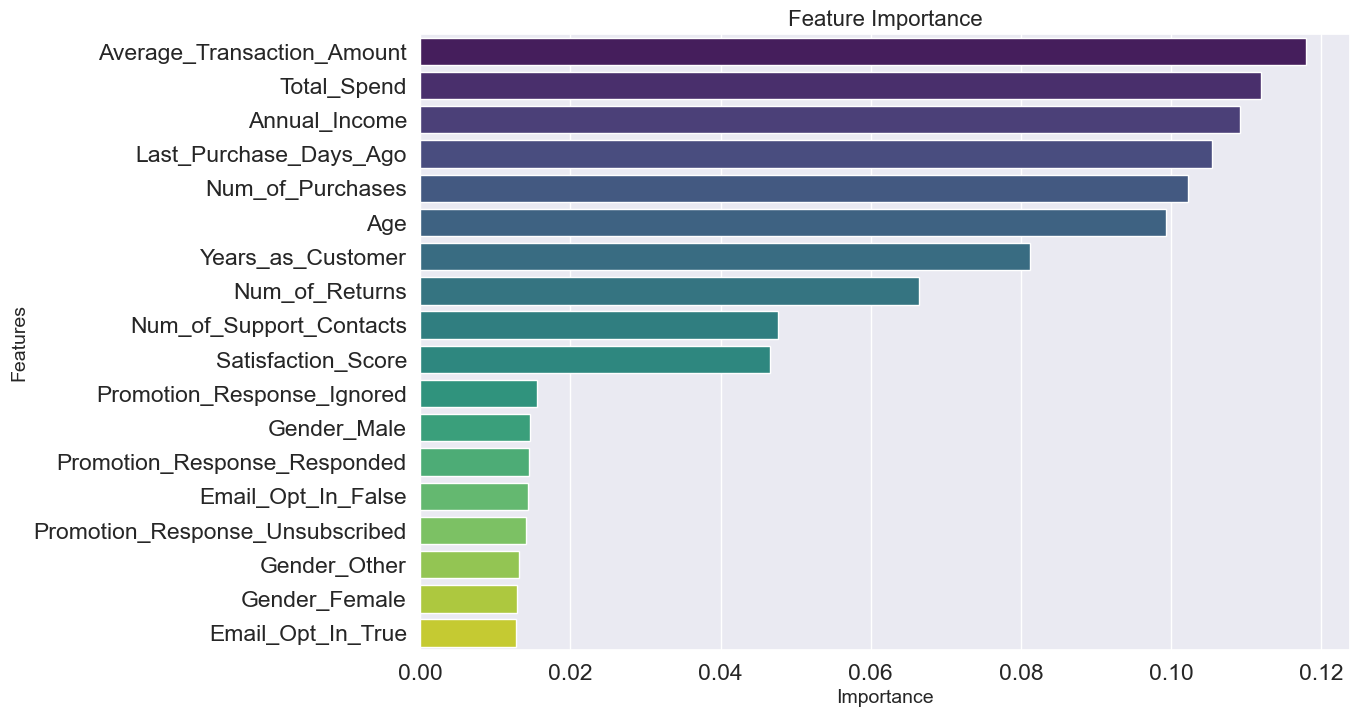

In [90]:
# Berechnung der Feature-Wichtigkeit
importances = rf.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualisierung der Feature-Wichtigkeit
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

Die obige Visualisierung zeigt die Wichtigkeit jedes Features in absteigender Reihenfolge. Diese Informationen sind nützlich, um zu verstehen, welche Merkmale den größten Einfluss auf die Vorhersage der Kundenabwanderung haben.

### Zusammenfassung der Churn-Analyse

In dieser Churn-Analyse haben wir den Random Forest-Klassifikator verwendet, um die Kundenabwanderung vorherzusagen. Nach der Datenvorbereitung, Modellierung und Bewertung des Modells haben wir die wichtigsten Merkmale identifiziert, die zur Vorhersage der Churn-Rate beitragen. Die Analyse der Feature-Wichtigkeit hat die folgenden fünf wichtigsten Merkmale hervorgehoben:

1. **Average Transaction Amount (Durchschnittlicher Transaktionsbetrag)**:
   - **Bedeutung**: Dieses Merkmal war das wichtigste für die Vorhersage der Kundenabwanderung. Ein hoher durchschnittlicher Transaktionsbetrag könnte auf wertvolle Kunden hinweisen, die weniger wahrscheinlich abwandern. Umgekehrt könnte ein niedriger Transaktionsbetrag ein Indikator für abwanderungsgefährdete Kunden sein.
   
2. **Total Spend (Gesamtausgaben)**:
   - **Bedeutung**: Die Gesamtausgaben eines Kunden sind ein starker Indikator für die Kundenbindung. Kunden, die mehr ausgeben, sind tendenziell loyaler und weniger wahrscheinlich abwanderungsgefährdet. Die Überwachung der Gesamtausgaben kann helfen, potenzielle Abwanderung frühzeitig zu erkennen.
   
3. **Annual Income (Jahreseinkommen)**:
   - **Bedeutung**: Das Jahreseinkommen eines Kunden korreliert oft mit dessen Kaufkraft und potenzieller Wertigkeit für das Unternehmen. Kunden mit höherem Einkommen könnten stabilere und regelmäßigere Kaufmuster aufweisen, was sie weniger anfällig für Abwanderung macht.

4. **Last Purchase Days Ago (Tage seit dem letzten Kauf)**:
   - **Bedeutung**: Dieses Merkmal gibt an, wie lange es her ist, dass ein Kunde zuletzt einen Kauf getätigt hat. Ein längerer Zeitraum seit dem letzten Kauf kann ein starkes Signal für eine bevorstehende Abwanderung sein. Kunden, die kürzlich gekauft haben, sind tendenziell engagierter und weniger wahrscheinlich abwanderungsgefährdet.
   
5. **Age (Alter)**:
   - **Bedeutung**: Das Alter der Kunden kann ebenfalls ein relevanter Faktor sein, da es mit unterschiedlichen Kaufverhalten und -präferenzen korrelieren kann. Verschiedene Altersgruppen könnten unterschiedliche Bindungsstrategien erfordern, um ihre Loyalität zu gewährleisten.

### Handlungsempfehlungen

Basierend auf den Ergebnissen dieser Analyse können die folgenden Maßnahmen ergriffen werden, um die Kundenbindung zu verbessern und die Abwanderungsrate zu senken:

1. **Personalisierte Angebote basierend auf Transaktionsverhalten**:
   - Kunden mit einem hohen durchschnittlichen Transaktionsbetrag und hohen Gesamtausgaben könnten durch exklusive Angebote und Belohnungsprogramme weiter gebunden werden.

2. **Einkommensbasierte Segmentierung**:
   - Kunden mit höherem Einkommen können gezielt mit Premium-Diensten und maßgeschneiderten Angeboten angesprochen werden, um ihre Loyalität zu erhöhen.

3. **Reaktivierungskampagnen**:
   - Kunden, die seit längerer Zeit keinen Kauf getätigt haben, sollten durch gezielte Reaktivierungskampagnen angesprochen werden, um sie zurückzugewinnen.

4. **Altersgerechte Marketingstrategien**:
   - Verschiedene Altersgruppen sollten mit auf sie zugeschnittenen Marketingbotschaften und -strategien angesprochen werden, um deren spezifische Bedürfnisse und Vorlieben zu berücksichtigen.

### Fazit

Die Churn-Analyse hat wertvolle Einblicke in die wichtigsten Faktoren geliefert, die die Kundenabwanderung beeinflussen. Durch gezielte Maßnahmen basierend auf diesen Erkenntnissen kann die Kundenbindung verbessert und die Abwanderungsrate effektiv gesenkt werden. Die kontinuierliche Überwachung dieser Merkmale und die Anpassung der Strategien sind entscheidend, um langfristigen Geschäftserfolg zu gewährleisten.